In [31]:
import csv
import pandas as pd
from collections import Counter
from glob import glob

def get_deletion_neighborhood(stringer):
    # returns a set of all single character deletions of a string (includes the string)
    return set([stringer] + [stringer[:x] + stringer[x+1:] for x in range(len(stringer))])

def find_bc_match(b, dd):
    # finds the correct barcode by looking for overlap with the deletion network
    # this accounts for all single errors - substitutions, insertions, and deletions
    if b in dd:
        return dd[b]
    else:
        hits = set()
        for b_edit in get_deletion_neighborhood(b):
            if b_edit in dd:
                hits.add(dd[b_edit])
        if len(hits) == 1:
            return hits.pop()
        else:
            return None

def call_bc_match(f):
    try: 
        td = pd.read_csv(f)
        dbc_counter = Counter()
        for entry in np.array(td.loc[td['Type'].isin(['DBC', 'unknown'])][['BC', 'Reads']]):
            check = find_bc_match(entry[0], del_dict)
            if check:
                dbc_counter[check] += entry[1]
        ebc_counter = Counter()
        for entry in np.array(td.loc[td['Type'].isin(['EBC', 'unknown'])][['BC', 'Reads']]):
            check = find_bc_match(entry[0], edel_dict)
            if check:
                ebc_counter[check] += entry[1]
        dbcs, ebcs = sorted([d for d in dbc_counter], key=lambda x: dbc_counter[x]*-1), sorted([e for e in ebc_counter], key=lambda x: ebc_counter[x]*-1)
        return [';'.join(dbcs), ';'.join([str(dbc_counter[d]) for d in dbcs]), ';'.join(ebcs), ';'.join([str(ebc_counter[e]) for e in ebcs])]
    except (FileNotFoundError, IOError):
        print("Wrong file or file path", f)
        return ['', '', '', '']

output_file = '../../output/BC_extraction/bcs_extracted_compiled.csv'
bfa_files = ['../../output/'+b+'/'+b+'_bc_counts_final_w_envs.csv' for b in ['hBFA1', 'hBFA2', 'dBFA2']]
# Reading in known barcodes
bcs_in_bfa = pd.concat([pd.read_csv(bfa_file)[['Diverse_BC', 'Environment_BC']] for bfa_file in bfa_files])

# Generating single-deletiion neighborhoods for each barcode for error correction
del_dict = dict()
edel_dict = dict()
for bc in set(bcs_in_bfa['Diverse_BC']):
    del_dict.update({d: bc for d in get_deletion_neighborhood(bc)})
for bc in set(bcs_in_bfa['Environment_BC']):
    edel_dict.update({d: bc for d in get_deletion_neighborhood(bc)})

bc_extract_files = glob('../../output/BC_extraction/bc_counts/*.csv')

with open(output_file, 'w') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(['File', 'dbcs', 'dbc_counts', 'ebcs', 'ebc_counts'])
    c = 0
    for f in bc_extract_files:
        m = call_bc_match(f)
        if m[0] != '':
            c += 1
        writer.writerow([f.split('/')[-1].split('.csv')[0]] + m)
    print('Found a dbc for', c, 'out of', len(bc_extract_files))

    
# Final steps (tranferred over from jupyter notebook)
    
def get_barcode(row):
    dbc_counts = [int(i) for i in str(row['dbc_counts']).split(';')]
    ebc_counts = [int(i) for i in str(row['ebc_counts']).split(';')]
    if len(dbc_counts) > 1:
        dbc_check = (dbc_counts[0] >= 2 and dbc_counts[0]/dbc_counts[1] >= 4)
    else:
        dbc_check = dbc_counts[0] >= 2
    if len(ebc_counts) > 1:
        ebc_check = (ebc_counts[0] >= 2 and ebc_counts[0]/ebc_counts[1] >= 4)
    else:
        ebc_check = ebc_counts[0] >= 2
    if dbc_check and ebc_check:
        return str(row['dbcs']).split(';')[0]+'_'+str(row['ebcs']).split(';')[0]
    else:
        return np.nan

bcd = pd.read_csv(output_file)
bcd = bcd[(bcd['dbc_counts'].notnull()) & (bcd['ebc_counts'].notnull())]
bcd['Barcode'] = bcd.apply(get_barcode, axis=1)
print(len(bcd[bcd['Barcode'].notnull()]), 'successfully called BC')

fitds = []
bc_recs = dict()
for bfa_name in ['dBFA2', 'hBFA1', 'hBFA2']:
    tmp = pd.read_csv('../Final_data_sets/'+bfa_name+'_all_fitness.csv')[['Barcode', 'Home_Environment']].drop_duplicates()
    fitds.append(tmp)
    bc_recs[bfa_name] = list(tmp['Barcode'])
    
def get_bfas(bc):
    return ';'.join([bfa_name for bfa_name in ['dBFA2', 'hBFA1', 'hBFA2'] if bc in bc_recs[bfa_name]])
    
fitd = pd.concat(fitds)
fitd['BFAs'] = fitd['Barcode'].apply(get_bfas)

td = bcd[['Barcode', 'File']].merge(fitd[['Barcode', 'BFAs']], on='Barcode', how='left')
td = td[td['Barcode'].notnull()].drop_duplicates()

# Adding file and folder info
folder_names = [
    'Dip_clone_Env',
    'CLM_R2_clones_1N_',
    'CLM_2N_Batch2',
    'GlyEtOH_2N_20170616',
    'GlyEtOH_1N',
    'CLM_2N',
    'FLC_R1_clones_1N',
    'FLC_R2_clones_1N',
    'FLC_2N_Plate1', 
    'FLC_2N_Plate3',
    'FLC_2N_Plate2',
    'GlyEtOH_1N',
    'CLM_clones_1N'
]
# have to sort longest to shortest to get the right one out of the filename
snv = sorted(folder_names, key=lambda x: -1*len(x))

def get_sn(f):
    for sn in snv:
        if f[:len(sn)]==sn:
            return sn
    return 'None'

def get_st(f):
    for sn in snv:
        if f[:len(sn)]==sn:
            return f[len(sn)+1:]
    return 'None'

td['Folder'] = td['File'].apply(get_sn)
td['Strain'] = td['File'].apply(get_st)
td.to_csv('../Final_data_sets/bc_assignments_plus.csv', index=False)
    


Found a dbc for 1130 out of 1328
793 successfully called BC


In [32]:
td2 = pd.read_csv('../../../../../PLT/2022/SLAMseq_pipeline/Final_data_sets/bc_assignments_plus.csv')
td2.head()

,Barcode,File,BFAs,Folder,Strain
0,AAATAAAATTAAAACAGAGTTTGGTCCCATGAACATATTTGTCAAT...,FLC_2N_Plate3_FLC-P3-E8-CGAGGCTG-TACTCCTT_S26,dBFA2;hBFA2,FLC_2N_Plate3,FLC-P3-E8-CGAGGCTG-TACTCCTT_S26
1,AGGAAAATGGCTAATTGTCTTAATGGTTCCCAAGCGAATTATATTT...,CLM_clones_1N_P1-G12-ATCTCAGG-ATTAGACG_S84,hBFA1;hBFA2,CLM_clones_1N,P1-G12-ATCTCAGG-ATTAGACG_S84
2,TTTCTAAATTCGAAGAACTTTGTTCGGCCGAAACAGGGTTGCGGGT...,GlyEtOH_1N_GE_1_C12_AGGCAGAA-TCGGTTAA,hBFA1,GlyEtOH_1N,GE_1_C12_AGGCAGAA-TCGGTTAA
3,TCGGAAAACCAGAAGTGCGTTAGGCGAATAGAATCATCTTACTTCT...,GlyEtOH_1N_GE_1_D10_all,hBFA1,GlyEtOH_1N,GE_1_D10_all
4,CCAGAAACTGGGAATAGCGTTGGTTGCGGTTAATGGCTTTCTTCTT...,Dip_clone_Env_dBFA2_WGS_10D_1_D4_S17,dBFA2,Dip_clone_Env,dBFA2_WGS_10D_1_D4_S17


In [33]:
td1bc = [i.replace('_', '') for i in td.Barcode]
bcs_missing = set(td2[~td2.Barcode.isin(td1bc)].Barcode)
len(bcs_missing)

55

In [34]:
len(td), len(set(td.Barcode)), len(td2), len(set(td2.Barcode))

(793, 600, 798, 618)

In [35]:
import matplotlib.pyplot as plt

(array([ 7.,  0.,  1.,  0.,  0.,  8.,  0.,  7.,  0., 32.]),
 array([2. , 2.4, 2.8, 3.2, 3.6, 4. , 4.4, 4.8, 5.2, 5.6, 6. ]),
 <a list of 10 Patch objects>)

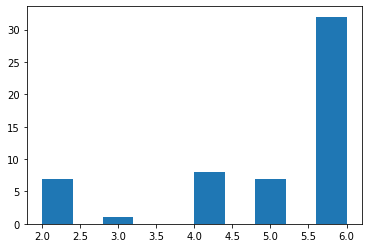

In [36]:
def reverse_complement(seq):
    """reverse complements a dna sequence (does not convert any non-atcg/ATCG characters)"""
    watson_crick = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G', 'a': 't', 't': 'a', 'g': 'c', 'c': 'g'}
    return ''.join([watson_crick.setdefault(c, c) for c in seq[::-1]])

# including the sequence between the barcodes to get the max AT run of the whole region (which is flanked by CG seqs)
middle_seq = 'ATAACTTCGTATAATGTATGCTATACGAAGTTAT'

def gc(s):
    return len([i for i in s if i in ['G', 'C']])
    
def sliding_window_min(bc, win_size):
    s = bc[:26] + middle_seq + reverse_complement(bc[26:])
    return min([gc(s[i:i+win_size]) for i in range(len(s)-win_size+1)])

def sliding_window_min2(bc, win_size):
    s = bc[:bc.index('_')] + middle_seq + reverse_complement(bc[bc.index('_')+1:])
    return min([gc(s[i:i+win_size]) for i in range(len(s)-win_size+1)])

bc_minners = [sliding_window_min(bc, 26) for bc in bcs_missing]
bc_others = [sliding_window_min2(bc, 26) for bc in td.Barcode]
plt.hist(bc_minners)

In [37]:
td[td.Barcode.apply(lambda b: sliding_window_min2(b, 26)<=4)]

,Barcode,File,BFAs,Folder,Strain
15,CTGTGAAAAGCGAACTTTGTTATATA_GCCGAAACAGGGTTGCGGG...,GlyEtOH_1N_GE_1_F10_all,NaN,GlyEtOH_1N,GE_1_F10_all
51,GCGTTAAAATTAAAAGGTTTTATAGG_CCATGAACATATTTGTCAA...,FLC_2N_Plate3_FLC-P3-G1-TAAGGCGA-ATTAGACG_S37,NaN,FLC_2N_Plate3,FLC-P3-G1-TAAGGCGA-ATTAGACG_S37
70,TACAAAATTAATAATTGGCTTTCTTT_CCATGAACATATTTGTCAA...,FLC_2N_Plate3_FLC-P3-D8-CGAGGCTG-TATGCAGT_S20,NaN,FLC_2N_Plate3,FLC-P3-D8-CGAGGCTG-TATGCAGT_S20
80,CTAATAAAGTTTAATGGAATTAGATT_CCATGAACATATTTGTCAA...,FLC_2N_Plate3_FLC-P3-F10-GTAGAGGA-AGGCTTAG_S34,NaN,FLC_2N_Plate3,FLC-P3-F10-GTAGAGGA-AGGCTTAG_S34
89,ATCAGAAAAGCAAACGTATTTAATTA_AACTAAATACCCTTTCAAT...,GlyEtOH_2N_20170616_Gly-D9-AAGAGGCA-TATGCAGT_S45,NaN,GlyEtOH_2N_20170616,Gly-D9-AAGAGGCA-TATGCAGT_S45
...,...,...,...,...,...
1421,GCTGAAAAAATAAATGGAGTTTGTTA_GGGACAAGTGGGTTGGAGG...,GlyEtOH_2N_20170616_Gly-E5-GGACTCCT-TACTCCTT_S53,NaN,GlyEtOH_2N_20170616,Gly-E5-GGACTCCT-TACTCCTT_S53
1438,AGGCAAACACTTAATTAGATTTAAAG_AACTAAATACCCTTTCAAT...,GlyEtOH_2N_20170616_Gly-F6-TAGGCATG-AGGCTTAG_S66,NaN,GlyEtOH_2N_20170616,Gly-F6-TAGGCATG-AGGCTTAG_S66
1439,TTGATAATATATAATATATTTGGGAA_TACATAAAAAGTTTAACGA...,GlyEtOH_2N_20170616_Gly-F7-CTCTCTAC-AGGCTTAG_S67,NaN,GlyEtOH_2N_20170616,Gly-F7-CTCTCTAC-AGGCTTAG_S67
1441,TTTCTAAATCTTAATCCAATTTCTAA_CATTTAATAGTGTTTGCGT...,GlyEtOH_2N_20170616_Gly-F9-AAGAGGCA-AGGCTTAG_S69,NaN,GlyEtOH_2N_20170616,Gly-F9-AAGAGGCA-AGGCTTAG_S69


In [39]:
len(td), len([i for i in td.File if i not in list(td2.File)]), len(td2), len([i for i in td2.File if i not in list(td.File)])

(793, 69, 798, 74)

In [40]:
fm = [i for i in td2.File if i not in list(td.File)]
td2[td2.File.isin(fm)]

,Barcode,File,BFAs,Folder,Strain
143,AGCAGAAATCTAAAGTATCTTGACTTTTCCCAAGCGAATTATATTT...,CLM_R2_clones_1N_P1-D8-CGAGGCTG-TATGCAGT_S44_L001,hBFA1,CLM_R2_clones_1N_,1-D8-CGAGGCTG-TATGCAGT_S44_L001
144,TTGAGAACACGGAACGGTATTTAGTCACGGGAAGCCAGTTGGGGCT...,CLM_R2_clones_1N_P1-D9-AAGAGGCA-TATGCAGT_S45_L001,NaN,CLM_R2_clones_1N_,1-D9-AAGAGGCA-TATGCAGT_S45_L001
535,AGTTGAATGAGTAACACGCTTTTGCATCCTAAACGGAATTTTTTCT...,FLC_R1_clones_1N_P2-H1-TCGCCTTA-TCTCTCCG_S181_...,hBFA1,FLC_R1_clones_1N,P2-H1-TCGCCTTA-TCTCTCCG_S181_L008
539,CCGGAAACTGGAAACAATTTTGCAATTTTGAAAAGAATTTGTCGTT...,FLC_R2_clones_1N_P1-A2-CTAGTACG-CTCTCTAT_S2_L004,hBFA1,FLC_R2_clones_1N,P1-A2-CTAGTACG-CTCTCTAT_S2_L004
540,CAATCAAGAACTAAAAGAATTAGCCCTTTGAAAAGAATTTGTCGTT...,FLC_R2_clones_1N_P1-A3-TTCTGCCT-CTCTCTAT_S3_L004,hBFA1,FLC_R2_clones_1N,P1-A3-TTCTGCCT-CTCTCTAT_S3_L004
...,...,...,...,...,...
623,ACAAAAAGATATAACAAGCTTGAAGACCCGAAAAAGTTTTTTATCT...,FLC_R2_clones_1N_P2-G8-CAGCCTCG-CGTCTAAT_S80_L005,hBFA1;hBFA2,FLC_R2_clones_1N,P2-G8-CAGCCTCG-CGTCTAAT_S80_L005
624,TTAGTAAACCCGAAGCCGCTTTATTATCCTAAACGGAATTTTTTCT...,FLC_R2_clones_1N_P2-H11-TCATGAGC-TCTCTCCG_S95_...,hBFA1,FLC_R2_clones_1N,P2-H11-TCATGAGC-TCTCTCCG_S95_L005
625,CGCTCAACTTATAACCCCTTTAAACTTTTGAAAAGAATTTGTCGTT...,FLC_R2_clones_1N_P2-H4-GCTCAGGA-TCTCTCCG_S88_L005,hBFA1,FLC_R2_clones_1N,P2-H4-GCTCAGGA-TCTCTCCG_S88_L005
626,ACAAAAAGATATAACAAGCTTGAAGACCCGAAAAAGTTTTTTATCT...,FLC_R2_clones_1N_P2-H5-AGGAGTCC-TCTCTCCG_S89_L005,hBFA1;hBFA2,FLC_R2_clones_1N,P2-H5-AGGAGTCC-TCTCTCCG_S89_L005


In [42]:
fm = [i for i in td.File if i not in list(td2.File)]
tttd = pd.read_csv('../../output/BC_extraction/bcs_extracted_compiled.csv')
tttd[tttd.File.isin(fm)].head(30)

,File,dbcs,dbc_counts,ebcs,ebc_counts
14,GlyEtOH_1N_GE_1_G11_CTCTCTAC-ATCGCGCC,TTCTCAAGCTTTAATAACTTTGCACC;TGCTGAACATGGAAACCAA...,17;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1,AATAGAATCATCTTACTTCTTATTAC;AGAAAAACCATTTTCGTAT...,18;2;1
62,CLM_2N_Batch2_CLM-2N-R1-2-A4_S48,AGGGGAACGGGAAAGGGAGTTGAGAC;CTTGTAATCGGGAAATTGG...,12;2;1;1;1;1;1;1,TTATTAACTTCATTAGTAATTTGTTG;GGGACAAGTGGGTTGGAGG...,20;4;2;1;1;1
141,CLM_2N_CLM-D-1-A4_S37,GGTATAAATTATAAATGAGTTTATTG;CTTTTAACTTAAAAAGAGG...,7;1;1;1;1;1;1;1;1;1,TTTTGAACCTTATTTGGCCTTGGGAG;GGGACAAGTGGGTTGGAGG...,11;2;1;1;1
143,CLM_2N_CLM-D-1-A8_S47,ACGTAAACCAAGAATTTATTTCCGAT;TATGTAATTCTGAAGGATC...,8;1;1;1;1;1,TTATTAACTTCATTAGTAATTTGTTG;ATTTCAAGATTCTTTACGG...,7;1;1;1
144,CLM_2N_CLM-D-1-A9_S52,ACGTAAACCAAGAATTTATTTCCGAT;AGGTTAATTTCAAAATTAT...,9;1;1;1;1,TTATTAACTTCATTAGTAATTTGTTG;TGCTAAAGTGTATTTTTCC...,11;1;1
145,CLM_2N_CLM-D-1-B10_S59,AATACAAACATTAAAGGACTTTTATA;AGGATAATTAGCAAGATTT...,4;1;1;1;1;1,ATTTCAAGATTCTTTACGGTTGGGGG;CATTTAATAGTGTTTGCGT...,5;1
147,CLM_2N_CLM-D-1-B4_S38,GGTATAAATTATAAATGAGTTTATTG;CAGTGAAAATAAAAGGTTA...,6;1;1;1;1;1;1;1;1,TTTTGAACCTTATTTGGCCTTGGGAG;GAACAAAAAATCTTGAGAC...,7;1;1;1;1
150,CLM_2N_CLM-D-1-B9_S53,AGGGGAACGGGAAAGGGAGTTGAGAC;AATGAAAGCCACAACTTGT...,13;1;1;1;1;1;1;1;1;1;1,TTATTAACTTCATTAGTAATTTGTTG;GGGACAAGTGGGTTGGAGG...,12;2;1;1;1;1
155,CLM_2N_CLM-D-1-C9_S54,GGTTCAATCATTAACTGAGTTCTGCG;AATTTAATATCTAAGAAGC...,9;1;1;1;1,ATTTCAAGATTCTTTACGGTTGGGGG;AAGGCAAGATTCTTGTTCT...,9;1
156,CLM_2N_CLM-D-1-D10_S61,ACGTAAACCAAGAATTTATTTCCGAT;TCGTAAATCTTGAACTAAG...,7;1;1;1;1;1;1;1,TTATTAACTTCATTAGTAATTTGTTG;TATCAAATACACTTACCTA...,8;1;1;1;1;1;1;1


In [29]:
bcd[bcd.File.isin(fm)]

,File,dbcs,dbc_counts,ebcs,ebc_counts,Barcode
222,CLM_R2_clones_1N_P1-D8-CGAGGCTG-TATGCAGT_S44_L001,AGCAGAAATCTAAAGTATCTTGACTT;CGACAAATCTGTAAGGCGG...,3;1;1;1,TTCCCAAGCGAATTATATTTTTGAGA;CACTTAACTTGGTTAACGT...,9;1;1,NaN
223,CLM_R2_clones_1N_P1-D9-AAGAGGCA-TATGCAGT_S45_L001,TTGAGAACACGGAACGGTATTTAGTC;CATTTAATTAGTAATAAGT...,2;1;1,ACGGGAAGCCAGTTGGGGCTTGCAGG;ACGTTAACATTCTTTACTC...,14;1;1;1;1,NaN
261,CLM_R2_clones_1N_P1-H10-GTAGAGGA-CGGAGAGA_S94_...,ATGTCAATATGTAAGATGCTTCGAAA;AGGGTAATTGCAAATGATT...,7;1;1;1;1,TACAAAACACGTTTTCGGCTTAGCAA;CGTAAAATGGGGTTGCCAA...,12;1;1;1;1,NaN
778,FLC_R1_clones_1N_P1-D12-GACGTCGA-GCGTAAGA_S48_...,GGGTCAAACATGAACAGGTTTGACAC;TCGCGAACAGGAAAGATGA...,20;2;1;1;1;1;1;1;1;1;1,TTTGAAAAGAATTTGTCGTTTTTGTC;GTGTCAATCGATTTTTTTG...,23;2;1;1;1,NaN
790,FLC_R1_clones_1N_P1-D7-GAGCGCTA-GCGTAAGA_S43_L008,ACAAAAAGATATAACAAGCTTGAAGA;TCCGGAACACGAAAAGAAA...,19;1;1;1;1;1;1;1;1;1,CCCGAAAAAGTTTTTTATCTTCAATG;ACGCAAATAGATTTGGGAT...,16;1;1;1,NaN
...,...,...,...,...,...,...
1109,FLC_R2_clones_1N_P2-G5-AGGAGTCC-CGTCTAAT_S77_L005,CTCGCAAGTGCAAATCTGTTTTAGTT;TCCATAATTGGGAATTGGA...,6;1,TCCTAAACGGAATTTTTTCTTCACCT;CAACAAACCACATTATGTC...,8;5,NaN
1110,FLC_R2_clones_1N_P2-G6-CATGCCTA-CGTCTAAT_S78_L005,ACTTCAACATTTAACCACGTTAGTGC,4,TTTGAAAAGAATTTGTCGTTTTTGTC;CAACAAACCACATTATGTC...,5;3,NaN
1112,FLC_R2_clones_1N_P2-G8-CAGCCTCG-CGTCTAAT_S80_L005,ACAAAAAGATATAACAAGCTTGAAGA;TCTATAATCGACAACATGT...,12;1;1,CCCGAAAAAGTTTTTTATCTTCAATG;CAACAAACCACATTATGTC...,9;8,NaN
1116,FLC_R2_clones_1N_P2-H11-TCATGAGC-TCTCTCCG_S95_...,TTAGTAAACCCGAAGCCGCTTTATTA;TCCAGAAAAGGCAAGCTAC...,3;1,TCCTAAACGGAATTTTTTCTTCACCT;CAACAAACCACATTATGTC...,6;4,NaN
